In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec
from datetime import datetime



#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

Various combined spectra

In [2]:
def spectra_adder(f_array, e_array, rcs = True):
    """
    Returns a variance-weighted coadd with standard error of the weighted mean (variance weights, scale corrected).
    f_array and e_arrays are collections of flux and error arrays, which should have the same lenth and wavelength scale
    """
    weights = 1 / (e_array**2)
    flux = np.average(f_array, axis =0, weights = weights)
    var = 1 / np.sum(weights, axis=0)
    if rcs:
        rcs = np.sum((((flux - f_array)**2) * weights), axis=0) / (len(f_array)-1) #reduced chi-squared
        error = (var * rcs)**0.5
    else:
        error = var**0.05
    return flux, error

In [3]:
path = 'lc_output/'
tbin = 100
x1ds = glob.glob('{}*{}s_x1d.fits'.format(path, tbin))
x1ds

['lc_output/oehua4010_100s_x1d.fits',
 'lc_output/oehua1010_100s_x1d.fits',
 'lc_output/oehua2010_100s_x1d.fits']

oehua4010


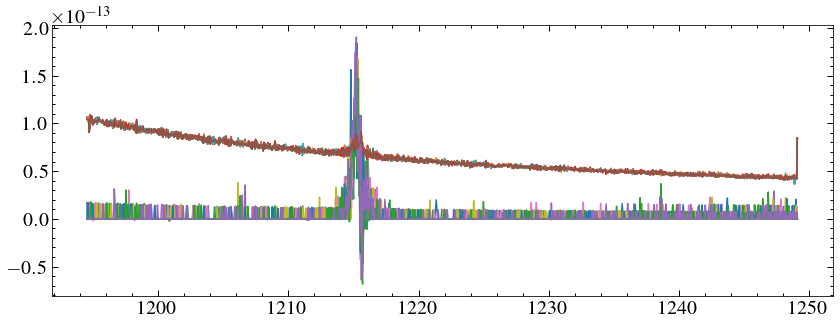

oehua1010


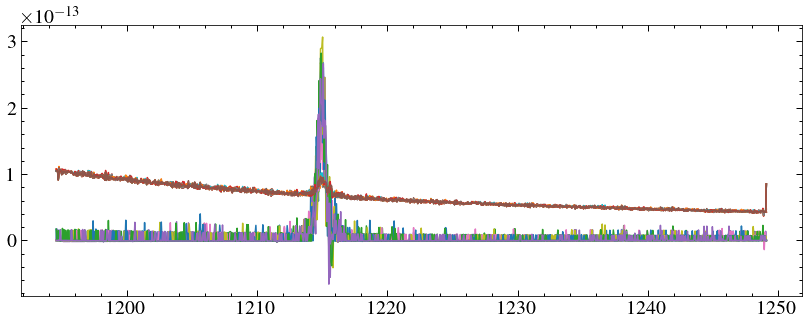

oehua2010


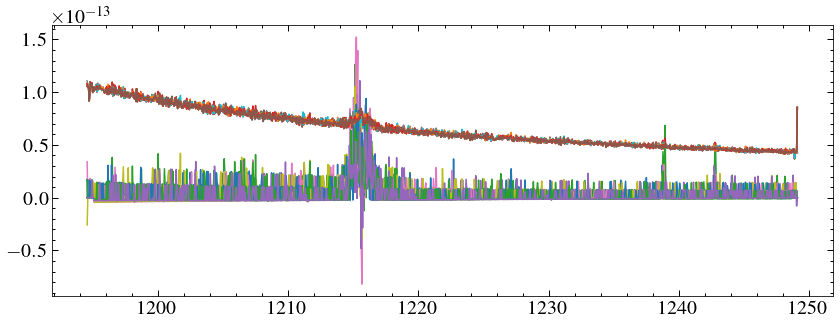

In [4]:
for x in x1ds:
    hdul = fits.open(x)
    print(hdul[0].header['ROOTNAME'])
    for ext in hdul[1::]: #spectra in every extension after the first
        data = ext.data[0]
        plt.plot(data['WAVELENGTH'], data['FLUX'])
        plt.plot(data['WAVELENGTH'], data['ERROR'])
       # plt.ylim(0, 1.1*max(data['FLUX']))
        #plt.show()
    hdul.close()
    plt.show()

2010 is the zero-velocity observation that we need to worry about.

In [5]:
x = x1ds[2]

In [6]:
def wavelength_edges(w):
    """
    Calulates w0 and w1
    """
    diff = np.diff(w)
    diff = np.insert(diff, 0, diff[0]) #adds an extravalue to make len(diff) = len(w)
    w0 = w - diff/2.
    w1 = w + diff/2.
    return w0, w1

band = [1210, 1220] #pick the wavelength range to integrate.

tstarts = []
tends = []
times = [] #arrays to put the light curve in
hdul = fits.open(x)
rootname = hdul[0].header['ROOTNAME']
# print(rootname)
for ext in hdul[1::]:
    data = ext.data[0]
    hdr = ext.header
    ti = (hdr['EXPSTART']+hdr['EXPEND'])/2 #work out the mid-point of the time bin and add it to the time array
    tstarts.append(hdr['EXPSTART'])
    tends.append(hdr['EXPEND'])
    times.append(ti)

# hdul.close()    
times, tstarts, tends = np.array(times), np.array(tstarts), np.array(tends)
print((tends -tstarts)*86400)
print(len(times))
print(len(hdul[1::]))
mid = int(len(hdul[1::])/2) #index of middle point (note 0-indexed)
print(mid)
print(times)
print(times[mid])

[99.99812425 99.99049567 99.99274998 99.9989968  99.9746237  99.99637913
 99.99199875 99.97750099 99.9987466  99.99025301 99.99362316 99.99800355
 99.99500492]
13
13
6
[59306.60862751 59306.60978487 59306.6109423  59306.61209974
 59306.61325715 59306.61441453 59306.615572   59306.61672934
 59306.61788677 59306.61904421 59306.62020158 59306.62135899
 59306.62251641]
59306.615571997594


0
[59306.615572]
1


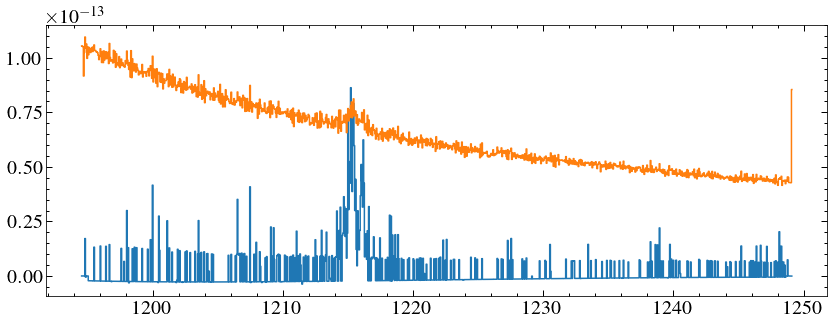

1
[59306.61441453 59306.615572   59306.61672934]
3


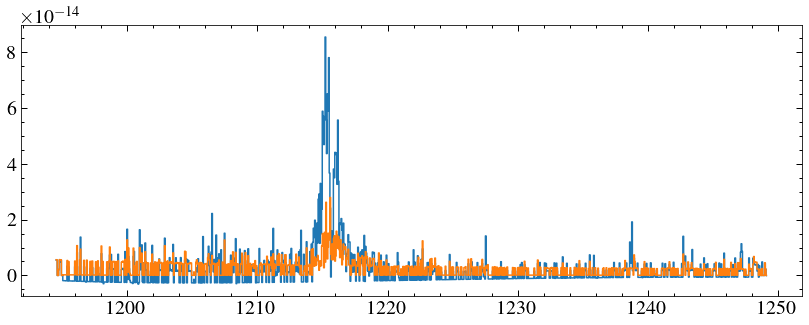

2
[59306.61325715 59306.61441453 59306.615572   59306.61672934
 59306.61788677]
5


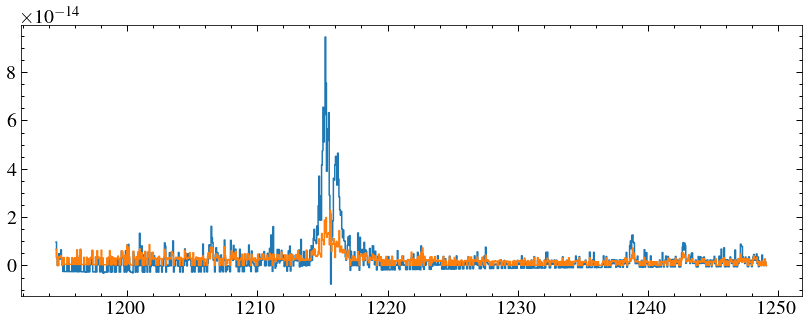

3
[59306.61209974 59306.61325715 59306.61441453 59306.615572
 59306.61672934 59306.61788677 59306.61904421]
7


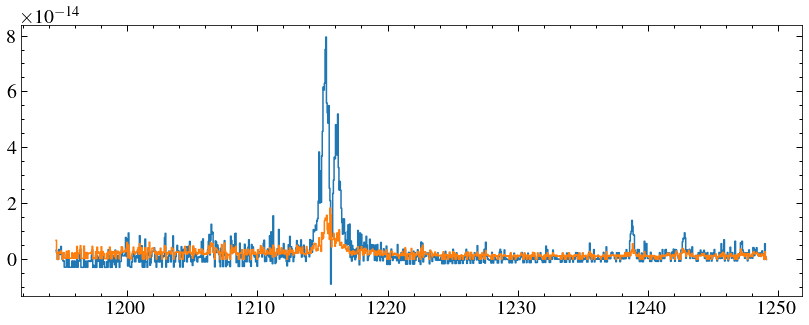

4
[59306.6109423  59306.61209974 59306.61325715 59306.61441453
 59306.615572   59306.61672934 59306.61788677 59306.61904421
 59306.62020158]
9


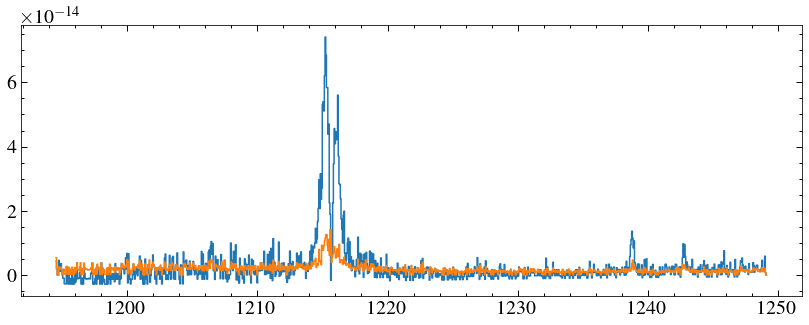

5
[59306.60978487 59306.6109423  59306.61209974 59306.61325715
 59306.61441453 59306.615572   59306.61672934 59306.61788677
 59306.61904421 59306.62020158 59306.62135899]
11


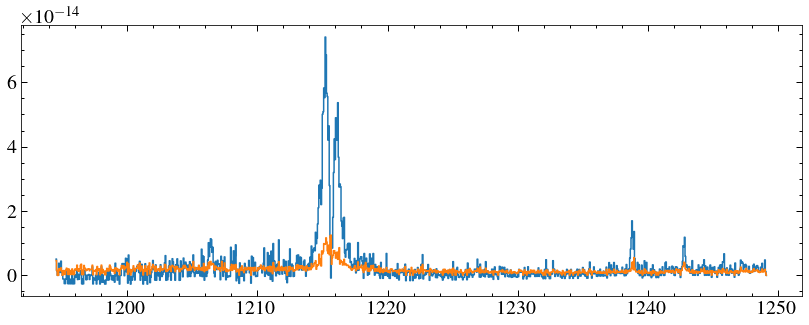

6
[59306.60862751 59306.60978487 59306.6109423  59306.61209974
 59306.61325715 59306.61441453 59306.615572   59306.61672934
 59306.61788677 59306.61904421 59306.62020158 59306.62135899
 59306.62251641]
13


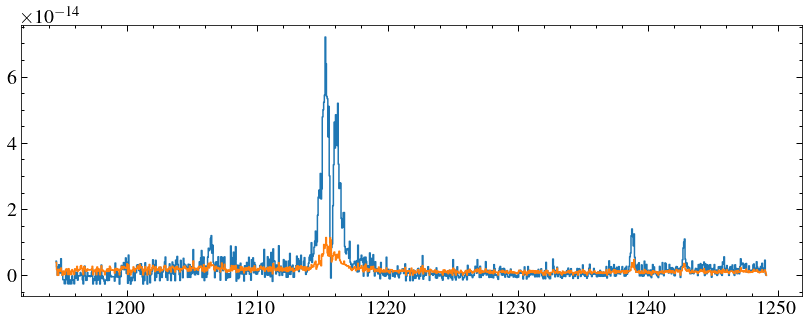

In [7]:
names = []
spectab= []
for i in range(mid+1):
    print(i)
    print(times[mid-i:mid+i+1])
    exts = hdul[1:][mid-i:mid+i+1]
    print(len(exts))
    fluxes = []
    errors = []
    for ext in exts:
        data = ext.data
        data = data[0]
        fluxes.append(data['FLUX'])
        errors.append(data['ERROR'])
    if i > 0:
        f, e = spectra_adder(np.array(fluxes), np.array(errors))
    else:
        f, e = fluxes[0], errors[0]
    w = data['WAVELENGTH']
    plt.step(w,f, where='mid')
    plt.step(w,e, where='mid')
    #plt.xlim(1210, 1220)
    plt.show()
    if i == 0:
        names.append('WAVELENGTH')
        spectab.append(w)
    names.append('FLUX_{}'.format((100+(i*200))))
    names.append('ERROR_{}'.format((100+(i*200))))
    spectab.append(f)
    spectab.append(e)
         #   plt.plot(data['WAVELENGTH'], data['FLUX'])
        #plt.show()

In [8]:
names

['WAVELENGTH',
 'FLUX_100',
 'ERROR_100',
 'FLUX_300',
 'ERROR_300',
 'FLUX_500',
 'ERROR_500',
 'FLUX_700',
 'ERROR_700',
 'FLUX_900',
 'ERROR_900',
 'FLUX_1100',
 'ERROR_1100',
 'FLUX_1300',
 'ERROR_1300']

In [9]:
savdat = Table(spectab, names=names)
ascii.write(savdat, '{}_expanding_split.escv'.format(rootname), format='ecsv', overwrite=True)

In [10]:
import stistools
path = '/media/david/5tb_storage1/eg_uma/hst/stis/data/'
stistools.doppinfo.Doppinfo('{}oehua1010_raw.fits'.format(path), dt=100, spt='{}oehua1010_spt.fits'.format(path))

The following tasks in the stistools package can be run with TEAL:
   basic2d      calstis     ocrreject     wavecal        x1d          x2d
# orbitper  doppzero      doppmag      doppmag_v    file
  5704.937  59306.409652  0.67734092   4.40354751   oehua1010_raw.fits[sci,1]
# time (MJD)   shift   radvel
59306.410734    0.07    0.462
59306.411891    0.14    0.940
59306.413048    0.22    1.407
59306.414206    0.29    1.857
59306.415363    0.35    2.284
59306.416521    0.41    2.684
59306.417678    0.47    3.051
59306.418835    0.52    3.382
59306.419993    0.56    3.672
59306.421150    0.60    3.918
59306.422308    0.63    4.116
59306.423465    0.66    4.265
59306.424623    0.67    4.362
59306.425780    0.68    4.406



/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/stsci/tools/nmpfit.py:10: UserWarning: NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.
  warnings.warn("NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.")
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/stsci/tools/gfit.py:20: UserWarning: GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it.Use astropy.modeling instead.
  warnings.warn("GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it."


Just 50/50 spectra

In [11]:
path = 'lc_output/'
tbin = 675
x1ds = glob.glob('{}*{}s_x1d.fits'.format(path, tbin))
x1ds

['lc_output/oehua4010_675s_x1d.fits',
 'lc_output/oehua1010_675s_x1d.fits',
 'lc_output/oehua2010_675s_x1d.fits']

oehua4010


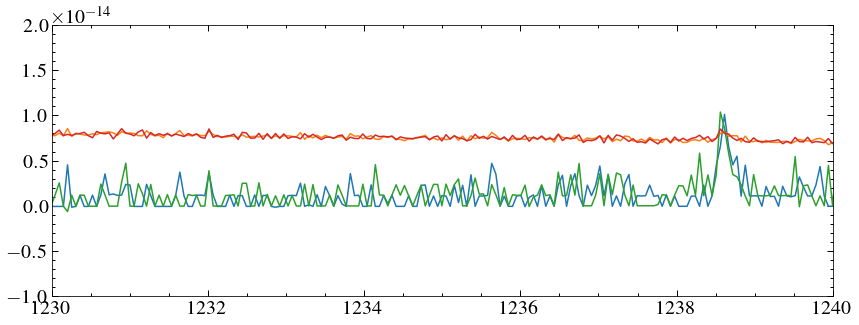

oehua1010


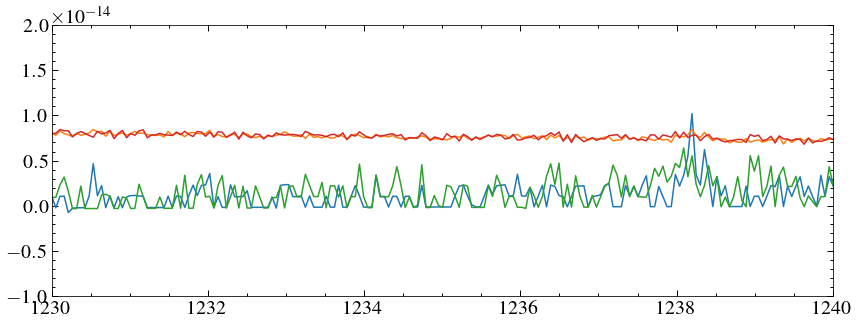

oehua2010


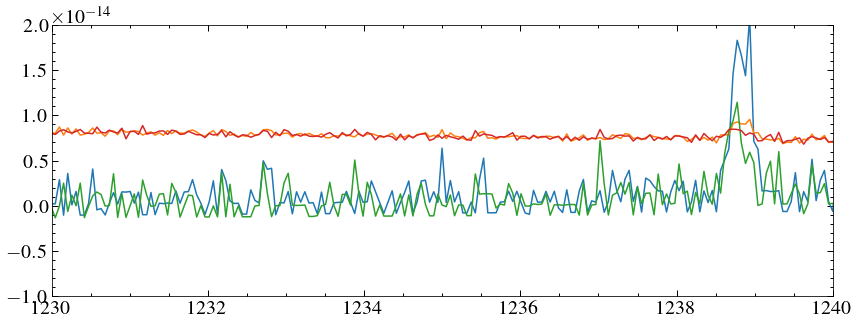

In [23]:
roots = []
waves = []
fluxes = []
errors = []
tstarts = []
tends = []

eg_uma = coord.SkyCoord(183.93308097127309, 52.51643832583794,
                        unit=(u.deg, u.deg), frame='icrs')
pole = coord.EarthLocation(0, 0,0*u.m)  

for x in x1ds:
    hdul = fits.open(x)
    print(hdul[0].header['ROOTNAME'])
    for ext in hdul[1::]: #spectra in every extension after the first
        data = ext.data[0]
        plt.plot(data['WAVELENGTH'], data['FLUX'])
        plt.plot(data['WAVELENGTH'], data['ERROR'])
        waves.append(data['WAVELENGTH'])
        fluxes.append(data['FLUX'])
        errors.append(data['ERROR'])
        roots.append(hdul[0].header['ROOTNAME'])
        tstart, tend = (ext.header['EXPSTART']), (ext.header['EXPEND']) #mjd
        times = time.Time([tstart, tend], format='mjd',scale='utc', location = pole) 
        ltt_helio = times.light_travel_time(eg_uma, 'heliocentric') 
        #print(times)
        #print(ltt_helio)
        tstart, tend = (times.utc + ltt_helio)[0]+2400000.5, (times.utc + ltt_helio)[1]+2400000.5  #HJD correction
        
        tstarts.append(tstart.value)
        tends.append(tend.value)
       # plt.ylim(0, 1.1*max(data['FLUX']))
        #plt.show()
    hdul.close()
    plt.xlim(1230, 1240)
    plt.ylim(-0.1e-13, 0.2e-13)
    plt.show()


In [13]:
print (roots)

['oehua4010', 'oehua4010', 'oehua1010', 'oehua1010', 'oehua2010', 'oehua2010']


oehua4010
2459306.7803389938


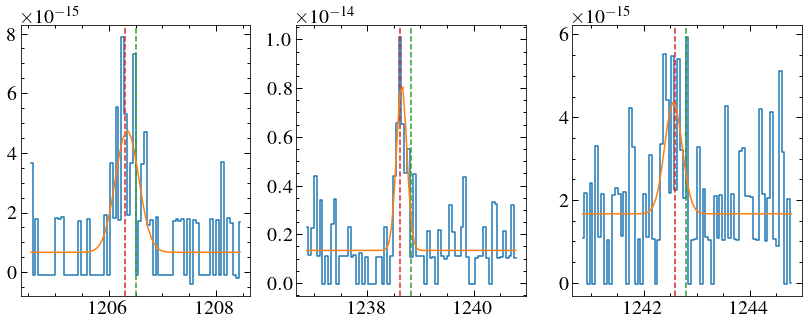

-43.390845400239826 3.5496677556658285
oehua4010
2459306.7881510863


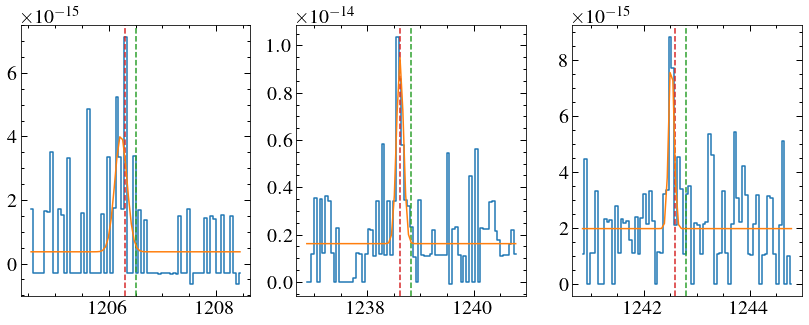

-58.80803081882003 6.4342759243084595
oehua1010
2459306.9138057884


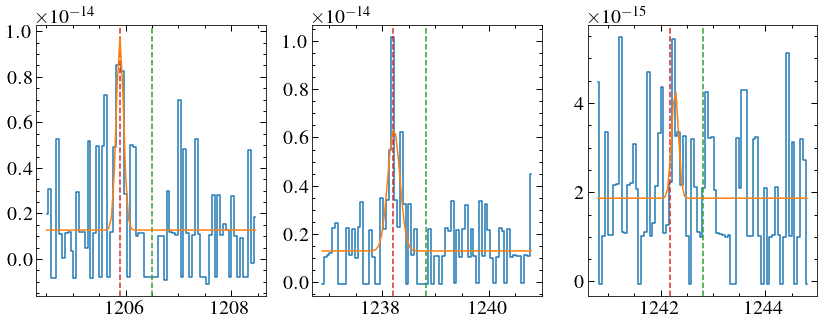

-146.7339486868295 4.484089167415212
oehua1010
2459306.9216178856


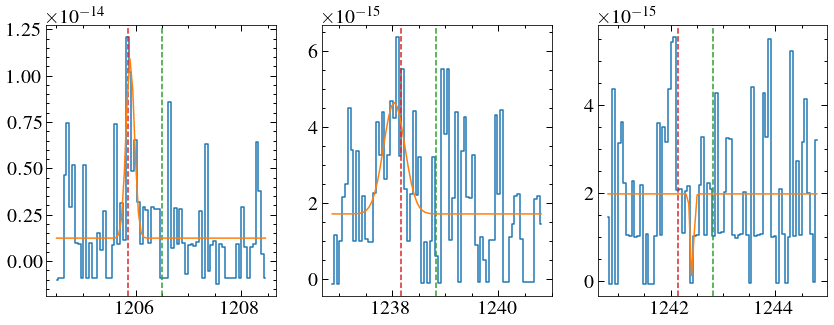

-149.09817848585624 7.6046047900539975
oehua2010
2459307.111112669


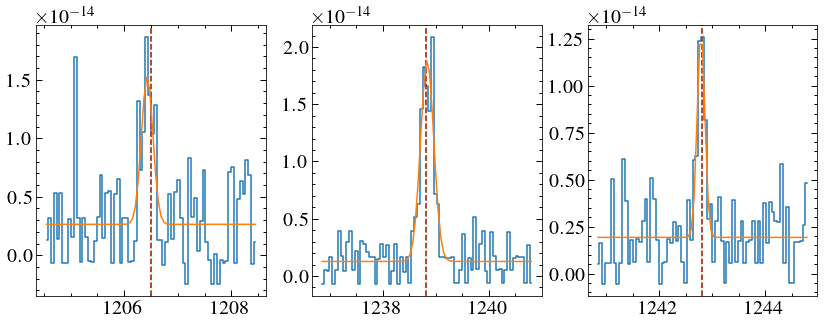

0.28940035452014384 4.216610951266421
oehua2010
2459307.1189248776


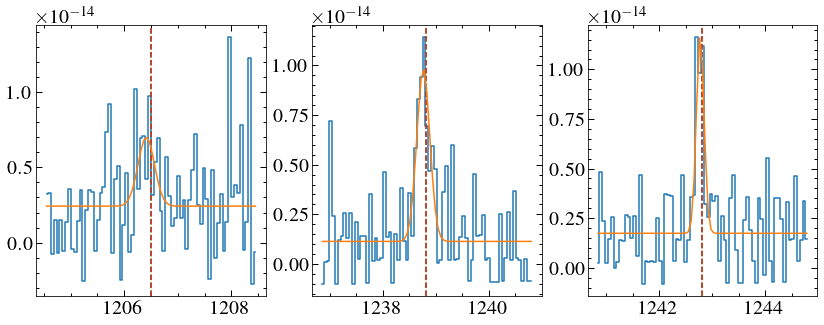

-10.198321797014588 2.844193986942628


In [49]:
def gauss_flux(amp, std, off, ae, se, oe):
    """
    Calcualates the flux and error of a Gaussian with amplitude and stddev amp and std, with offset off
    """
    off_err = 0
    if off != 0.0:
        amp += (-1*off)
        off_err = (oe/off)**2
        
    flux = ((2*np.pi)**0.5) * amp * std
    error = flux * (((ae/amp)**2)+((se/std)**2)+off_err)**0.5
    return flux, error



def dv_average(dvs, es):
    """
    Returns a variance-weighted dv with standard error of the weighted mean (variance weights, scale corrected).
    
    """
    weights = 1 / (es**2)
    dv = np.average(dvs, weights = weights)
    var = 1 / np.sum(weights)
    rcs = np.sum((((dv - dvs)**2) * weights)) / (len(dvs)-1) #reduced chi-squared
    error = (var * rcs)**0.5
    return dv, error

lines = [1206.499, 1238.821, 1242.804]
names = ['Si\,{\sc iii}', 'N\,{\sc v}', 'N\,{\sc v}']
fitter = fitting.LevMarLSQFitter()
lya = 1215.67

deltavs = []
deltav_errs = []

line_fluxes = np.ndarray(shape=(len(waves), len(lines)))
line_errors = np.ndarray(shape=(len(waves), len(lines)))

line_dvs = np.ndarray(shape=(len(waves), len(lines)))
line_dves = np.ndarray(shape=(len(waves), len(lines)))

dates = []


guess_dv = np.array([-50, -50,  -150, -160, -0, -0])*u.km/u.s
for i, w in enumerate(waves):
    print(roots[i])
    dates.append((tstarts[i] +tends[i])/2)
    print(tstarts[i])
    w, f, e = waves[i], fluxes[i], errors[i]
    stis_mask = (w < lines[0]-2) | (w > lines[0]+2) & (w < 1210) | (w > 1220) & (w < lines[1]-2) | (w > lines[1]+2) & (w < lines[2]-2) | (w > lines[2]+2) 
    wi, fi, ei = w[stis_mask], f[stis_mask], e[stis_mask]
    poly_init = models.Polynomial1D(2)
    poly_fit =  fitting.LinearLSQFitter()(poly_init, wi, fi)#, weights = 1/ei)
 #   f = f - poly_fit(w)
    
    dvs = []
    dves = []
    for j, line in enumerate(lines): #nv 1242 is only barely detected
        plt.subplot(1, 3, j+1)
        guess_line = guess_dv[i].to(u.AA,  equivalencies=u.doppler_optical(line*u.AA)).value
#         print(guess_line)
        mask = (w > line-2) & (w < line+2)
#         fline = convolve(fline,Box1DKernel(3))

        wline, fline, eline = w[mask], f[mask], e[mask]
        plt.step(wline, fline, where='mid')
      #  plt.step(wline, eline, where='mid')
        plt.axvline(line, ls='--', c='C2')
        plt.axvline(guess_line, ls='--', c='C3')
        gg_init = models.Const1D(0)+models.Gaussian1D(1e-14, guess_line, 0.1)
        gg_fit = fitter(gg_init, wline, fline, maxiter=100000)
      #  print(gg_fit)
        fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
       # print(fit_e)
        plt.plot(wline, gg_fit(wline))
        obs_line = gg_fit[1].mean.value*u.AA
        dv = obs_line.to(u.km/u.s,  equivalencies=u.doppler_optical(line*u.AA))
       # print(fit_e)
        eup = (obs_line+fit_e[2]*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(line*u.AA))
        edo = (obs_line-fit_e[2]*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(line*u.AA))
        dve= np.mean([abs(dv-eup).value, abs(dv-edo).value])*u.km/u.s
#         print(dv, dve)
        dvs.append(dv.value)
        dves.append(dve.value)
        
        line_flux, line_fluxerr = gauss_flux(gg_fit[1].amplitude, gg_fit[1].stddev, gg_fit[0].amplitude, fit_e[1], fit_e[3], fit_e[0])
       # print(line_flux, line_fluxerr)
        line_fluxes[i, j] = line_flux
        line_errors[i, j] = line_fluxerr
        line_dvs[i, j] = dv.value
        line_dves[i, j] = dve.value
      #  print(line_fluxes) 
    plt.show()
    dv_spec, dve_spec = dv_average(np.array(dvs), np.array(dves))
    if tstarts[i] in [2459306.9216178856]:#, 2459307.111112669]:
        dv_spec, dve_spec = dvs[0], dves[0] #one of the NV lines is a v bad fit
  
        
#     if tstarts[i] == 59306.6158613321:
#         dv_spec, dve_spec = dv_average(np.array(dvs[1:]), np.array(dves[1:])) #one of the SiIII lines is a v bad fit
    deltavs.append(dv_spec)
    deltav_errs.append(dve_spec)
    print(dv_spec, dve_spec)
       
dates, deltavs, deltav_errs = np.array(dates), np.array(deltavs), np.array(deltav_errs)
     

[ -43.3908454   -58.80803082 -146.73394869 -149.09817849  -17.4284704
  -10.1983218 ]


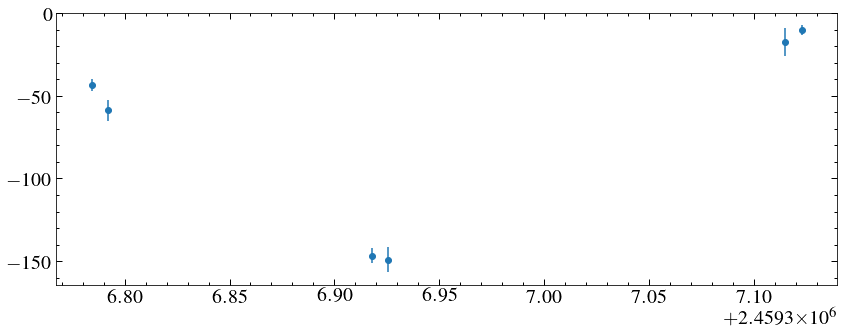

In [28]:
plt.errorbar(dates, deltavs, yerr= deltav_errs, marker='o', ls='none')
print(deltavs)

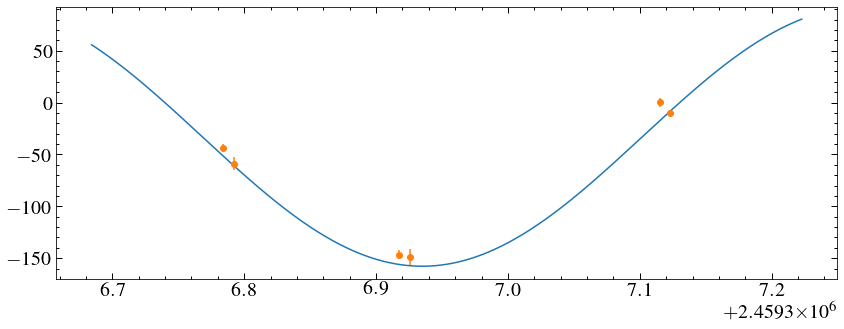

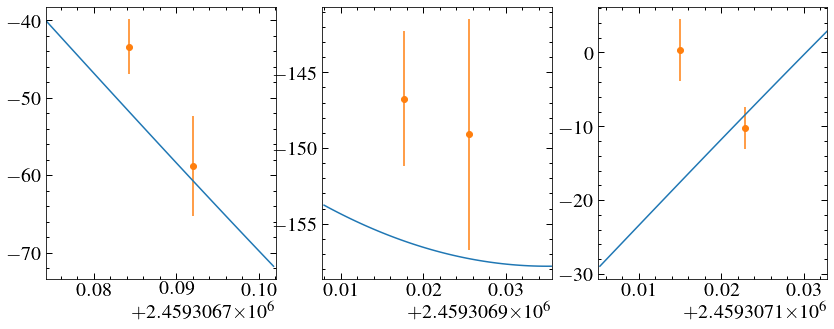

In [50]:
import math as mt

gamma = -32.9*u.km/u.s
k2 = 124.9*u.km/u.s
# k2 = 126.0*u.km/u.s # (2.5)
p = 961.31*u.min
pd = 0.66757877*u.d #(54)
eph =2444279.9151*u.d #(18)

day = mt.floor(np.min(dates))



# phase_time = np.arange(0,1.01, 0.01)
orbit = models.Sine1D(k2.value, 1/pd.value, phase=0.5, fixed=dict(amplitude=True, frequency=True))+models.Const1D(gamma.value, fixed=dict(amplitude=True))
orbfit = fitter(orbit, dates, deltavs, weights=1/deltav_errs, maxiter=10000)
# phase_curve = phase_orbit(phase_time)
orbittimes = np.linspace(min(dates)-0.1, max(dates)+0.1, 1000)
# orbittimes = np.linspace(0, 1, 1000)

plt.plot(orbittimes, orbfit(orbittimes))
plt.errorbar(dates, deltavs, yerr= deltav_errs, marker='o', ls='none')
# print(dates)
plt.show()

orbitcurve =  orbfit(orbittimes)

for i, cut in enumerate((2, 4, 6)):
    plt.subplot(1, 3, i+1)
    mask = (orbittimes > dates[cut-2:cut][0]-0.01) & (orbittimes < dates[cut-2:cut][1]+0.01)
    plt.plot(orbittimes[mask], orbitcurve[mask])
    plt.errorbar(dates[cut-2:cut], deltavs[cut-2:cut], yerr= deltav_errs[cut-2:cut], marker='o', ls='none')
    plt.xlim(dates[cut-2:cut][0]-0.01, dates[cut-2:cut][1]+0.01)
#     plt.ylim()